In [1]:
%matplotlib inline


.. currentmodule:: dgl

Batched Graph Classification with DGL
=====================================

**Author**: `Mufei Li <https://github.com/mufeili>`_,
`Minjie Wang <https://jermainewang.github.io/>`_,
`Zheng Zhang <https://shanghai.nyu.edu/academics/faculty/directory/zheng-zhang>`_.

Graph classification is an important problem
with applications across many fields -- bioinformatics, chemoinformatics, social
network analysis, urban computing and cyber-security. Applying graph neural
networks to this problem has been a popular approach recently (
`Ying et al., 2018 <https://arxiv.org/abs/1806.08804>`_,
`Cangea et al., 2018 <https://arxiv.org/abs/1811.01287>`_,
`Knyazev et al., 2018 <https://arxiv.org/abs/1811.09595>`_,
`Bianchi et al., 2019 <https://arxiv.org/abs/1901.01343>`_,
`Liao et al., 2019 <https://arxiv.org/abs/1901.01484>`_,
`Gao et al., 2019 <https://openreview.net/forum?id=HJePRoAct7>`_).

This tutorial demonstrates:
 * batching multiple graphs of variable size and shape with DGL
 * training a graph neural network for a simple graph classification task



Simple Graph Classification Task
--------------------------------
In this tutorial, we will learn how to perform batched graph classification
with dgl via a toy example of classifying 8 types of regular graphs as below:

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/dataset_overview.png)

    :align: center

We implement a synthetic dataset :class:`data.MiniGCDataset` in DGL. The dataset has 8
different types of graphs and each class has the same number of graph samples.



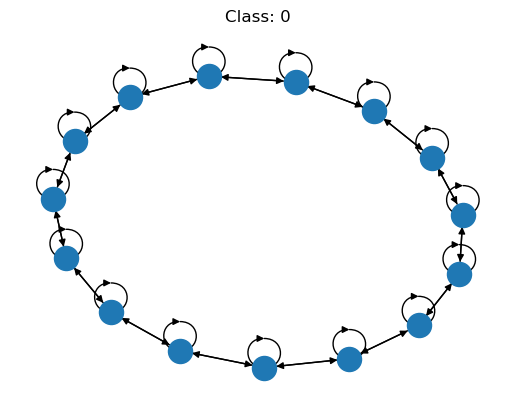

In [3]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
# A dataset with 80 samples, each graph is
# of size [10, 20]
dataset = MiniGCDataset(80, 10, 20)
graph, label = dataset[0]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

Form a graph mini-batch
-----------------------
To train neural networks more efficiently, a common practice is to **batch**
multiple samples together to form a mini-batch. Batching fixed-shaped tensor
inputs is quite easy (for example, batching two images of size $28\times 28$
gives a tensor of shape $2\times 28\times 28$). By contrast, batching graph inputs
has two challenges:

* Graphs are sparse.
* Graphs can have various length (e.g. number of nodes and edges).

To address this, DGL provides a :func:`dgl.batch` API. It leverages the trick that
a batch of graphs can be viewed as a large graph that have many disjoint
connected components. Below is a visualization that gives the general idea:

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/batch.png)

    :width: 400pt
    :align: center

We define the following ``collate`` function to form a mini-batch from a given
list of graph and label pairs.



In [4]:
import dgl

def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

The return type of :func:`dgl.batch` is still a graph (similar to the fact that
a batch of tensors is still a tensor). This means that any code that works
for one graph immediately works for a batch of graphs. More importantly,
since DGL processes messages on all nodes and edges in parallel, this greatly
improves efficiency.

Graph Classifier
----------------
The graph classification can be proceeded as follows:

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/graph_classifier.png)


From a batch of graphs, we first perform message passing/graph convolution
for nodes to "communicate" with others. After message passing, we compute a
tensor for graph representation from node (and edge) attributes. This step may
be called "readout/aggregation" interchangeably. Finally, the graph
representations can be fed into a classifier $g$ to predict the graph labels.

Graph Convolution
-----------------
Our graph convolution operation is basically the same as that for GCN (checkout our 
`tutorial <https://docs.dgl.ai/tutorials/models/1_gnn/1_gcn.html>`_). The only difference is
that we replace $h_{v}^{(l+1)} = \text{ReLU}\left(b^{(l)}+\sum_{u\in\mathcal{N}(v)}h_{u}^{(l)}W^{(l)}\right)$ by
$h_{v}^{(l+1)} = \text{ReLU}\left(b^{(l)}+\frac{1}{|\mathcal{N}(v)|}\sum_{u\in\mathcal{N}(v)}h_{u}^{(l)}W^{(l)}\right)$.
The replacement of summation by average is to balance nodes with different
degrees, which gives a better performance for this experiment.

Note that the self edges added in the dataset initialization allows us to
include the original node feature $h_{v}^{(l)}$ when taking the average.



In [5]:
import dgl.function as fn
import torch
import torch.nn as nn


# Sends a message of node feature h.
msg = fn.copy_src(src='h', out='m')

def reduce(nodes):
    """Take an average over all neighbor node features hu and use it to
    overwrite the original node feature."""
    accum = torch.mean(nodes.mailbox['m'], 1)
    return {'h': accum}

class NodeApplyModule(nn.Module):
    """Update the node feature hv with ReLU(Whv+b)."""
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}

class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        # Initialize the node features with h.
        g.ndata['h'] = feature
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

Readout and Classification
--------------------------
For this demonstration, we consider initial node features to be their degrees.
After two rounds of graph convolution, we perform a graph readout by averaging
over all node features for each graph in the batch

\begin{align}h_g=\frac{1}{|\mathcal{V}|}\sum_{v\in\mathcal{V}}h_{v}\end{align}

In DGL, :func:`dgl.mean_nodes` handles this task for a batch of
graphs with variable size. We then feed our graph representations into a
classifier with one linear layer to obtain pre-softmax logits.



In [16]:
import torch.nn.functional as F


class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()

        self.layers = nn.ModuleList([
            GCN(in_dim, hidden_dim, F.relu),
            GCN(hidden_dim, hidden_dim, F.relu)])
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # For undirected graphs, in_degree is the same as
        # out_degree.
        print("Classifier_forward:\n", g)
        h = g.in_degrees().view(-1, 1).float()
        print(h.shape)
        for conv in self.layers:
            h = conv(g, h)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

Setup and Training
------------------
We create a synthetic dataset of $400$ graphs with $10$ ~
$20$ nodes. $320$ graphs constitute a training set and
$80$ graphs constitute a test set.



In [17]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Create training and test sets.
trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=32, shuffle=True,
                         collate_fn=collate)

# Create model
model = Classifier(1, 256, trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

epoch_losses = []
for epoch in range(1):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        print("train_step:\n", bg)
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

train_step:
 Graph(num_nodes=446, num_edges=2550,
      ndata_schemes={}
      edata_schemes={})
Classifier_forward:
 Graph(num_nodes=446, num_edges=2550,
      ndata_schemes={}
      edata_schemes={})
torch.Size([446, 1])
train_step:
 Graph(num_nodes=460, num_edges=3276,
      ndata_schemes={}
      edata_schemes={})
Classifier_forward:
 Graph(num_nodes=460, num_edges=3276,
      ndata_schemes={}
      edata_schemes={})
torch.Size([460, 1])
train_step:
 Graph(num_nodes=428, num_edges=2540,
      ndata_schemes={}
      edata_schemes={})
Classifier_forward:
 Graph(num_nodes=428, num_edges=2540,
      ndata_schemes={}
      edata_schemes={})
torch.Size([428, 1])
train_step:
 Graph(num_nodes=438, num_edges=2736,
      ndata_schemes={}
      edata_schemes={})
Classifier_forward:
 Graph(num_nodes=438, num_edges=2736,
      ndata_schemes={}
      edata_schemes={})
torch.Size([438, 1])
train_step:
 Graph(num_nodes=426, num_edges=2378,
      ndata_schemes={}
      edata_schemes={})
Classifier_

The learning curve of a run is presented below:



In [ ]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

The trained model is evaluated on the test set created. Note that for deployment
of the tutorial, we restrict our running time and you are likely to get a higher
accuracy ($80$ % ~ $90$ %) than the ones printed below.



In [ ]:
model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

Below is an animation where we plot graphs with the probability a trained model
assigns its ground truth label to it:

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/test_eval4.gif)


To understand the node/graph representations a trained model learnt,
we use `t-SNE, <https://lvdmaaten.github.io/tsne/>`_ for dimensionality reduction
and visualization.

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/tsne_node2.png)

    :align: center

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/tsne_graph2.png)

    :align: center

The two small figures on the top separately visualize node representations after $1$,
$2$ layers of graph convolution and the figure on the bottom visualizes
the pre-softmax logits for graphs as graph representations.

While the visualization does suggest some clustering effects of the node features,
it is expected not to be a perfect result as node degrees are deterministic for
our node features. Meanwhile, the graph features are way better separated.

What's Next?
------------
Graph classification with graph neural networks is still a very young field
waiting for folks to bring more exciting discoveries! It is not easy as it
requires mapping different graphs to different embeddings while preserving
their structural similarity in the embedding space. To learn more about it,
`"How Powerful Are Graph Neural Networks?" <https://arxiv.org/abs/1810.00826>`_
in ICLR 2019 might be a good starting point.

With regards to more examples on batched graph processing, see

* our tutorials on `Tree LSTM <https://docs.dgl.ai/tutorials/models/2_small_graph/3_tree-lstm.html>`_ and `Deep Generative Models of Graphs <https://docs.dgl.ai/tutorials/models/3_generative_model/5_dgmg.html>`_
* an example implementation of `Junction Tree VAE <https://github.com/dmlc/dgl/tree/master/examples/pytorch/jtnn>`_

